# Inductive iris waveguide filter

This example shows how to build and analyze a four-pole
X-Band waveguide filter using inductive irises.

Keywords: **HFSS**, **modal**, **waveguide filter**.

<img src="_static/wgf.png" width="500">

## Perform imports and define constants

Perform required imports.


In [1]:
import os
import tempfile
import time

import ansys.aedt.core

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Launch AEDT

### Define parameters and values for waveguide iris filter

Define these parameters:

l: Length of the cavity from the mid-point of one iris
   to the midpoint of the next iris

w: Width of the iris opening

a: Long dimension of the waveguide cross-section (X-Band)

b: Short dimension of the waveguide cross-section

t: Metal thickness of the iris insert

In [3]:
wgparams = {
    "l": [0.7428, 0.82188],
    "w": [0.50013, 0.3642, 0.3458],
    "a": 0.4,
    "b": 0.9,
    "t": 0.15,
    "units": "in",
}

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

### Create HFSS design

In [5]:
project_name = os.path.join(temp_folder.name, "waveguide.aedt")
hfss = ansys.aedt.core.Hfss(
    project=project_name,
    version=AEDT_VERSION,
    design="filter",
    solution_type="Modal",
    non_graphical=NG_MODE,
    new_desktop=True,
    close_on_exit=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_c5b583b1-2f61-443b-81ff-dc45a1554eeb.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 5200.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project waveguide has been created.


PyAEDT INFO: Added design 'filter' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


### Initialize design parameters

In [6]:
hfss.modeler.model_units = "in"  # Set to inches
var_mapping = dict()  # Used by parse_expr to parse expressions.
for key in wgparams:
    if type(wgparams[key]) in [int, float]:
        hfss[key] = str(wgparams[key]) + wgparams["units"]
        var_mapping[key] = wgparams[key]  # Used for expression parsing.
    elif type(wgparams[key]) == list:
        count = 1
        for v in wgparams[key]:
            this_key = key + str(count)
            hfss[this_key] = str(v) + wgparams["units"]
            var_mapping[
                this_key
            ] = v  # Used to parse expressions and generate numerical values.
            count += 1

if len(wgparams["l"]) % 2 == 0:
    zstart = "-t/2"  # Even number of cavities, odd number of irises.
    is_even = True
else:
    zstart = "l1/2 - t/2"  # Odd number of cavities, even number of irises.
    is_even = False

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


### Draw parametric waveguide filter

Define a function to place each iris at the correct longitudinal (z) position,
Loop from the largest index (interior of the filter) to 1, which is the first
iris nearest the waveguide ports.

In [7]:
def place_iris(z_pos, dz, param_count):
    w_str = "w" + str(param_count)  # Iris width parameter as a string.
    this_name = "iris_a_" + str(param_count)  # Iris object name in the HFSS project.
    iris_new = []  # Return a list of the two objects that make up the iris.
    if this_name in hfss.modeler.object_names:
        this_name = this_name.replace("a", "c")
    iris_new.append(
        hfss.modeler.create_box(
            ["-b/2", "-a/2", z_pos],
            ["(b - " + w_str + ")/2", "a", dz],
            name=this_name,
            material="silver",
        )
    )
    iris_new.append(iris_new[0].mirror([0, 0, 0], [1, 0, 0], duplicate=True))
    return iris_new

### Place irises

Place the irises from inner (highest integer) to outer.

In [8]:
zpos = zstart
for count in reversed(range(1, len(wgparams["w"]) + 1)):
    if count < len(wgparams["w"]):  # Update zpos
        zpos = zpos + "".join([" + l" + str(count) + " + "])[:-3]
        iris = place_iris(zpos, "t", count)
        iris = place_iris("-(" + zpos + ")", "-t", count)

    else:  # Place first iris
        iris = place_iris(zpos, "t", count)
        if not is_even:
            iris = place_iris("-(" + zpos + ")", "-t", count)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


### Draw full waveguide with ports

Use ``hfss.variable_manager``, which acts like a dictionary, to return an instance of
the ``ansys.aedt.core.application.variables.VariableManager`` class for any variable.
The ``VariableManager`` instance takes the HFSS variable name as a key.
``VariableManager`` properties enable access to update, modify, and
evaluate variables.

In [9]:
var_mapping["port_extension"] = 1.5 * wgparams["l"][0]
hfss["port_extension"] = str(var_mapping["port_extension"]) + wgparams["units"]
hfss["wg_z_start"] = "-(" + zpos + ") - port_extension"
hfss["wg_length"] = "2*(" + zpos + " + port_extension )"
wg_z_start = hfss.variable_manager["wg_z_start"]
wg_length = hfss.variable_manager["wg_length"]
hfss["u_start"] = "-a/2"
hfss["u_end"] = "a/2"
hfss.modeler.create_box(
    ["-b/2", "-a/2", "wg_z_start"],
    ["b", "a", "wg_length"],
    name="waveguide",
    material="vacuum",
)

waveguide

### Draw the entire waveguide

The variable ``# wg_z`` is the total length of the waveguide, including the port extension.
Note that the ``.evaluated_value`` provides access to the numerical value of
``wg_z_start``, which is an expression in HFSS.

In [10]:
wg_z = [
    wg_z_start.evaluated_value,
    hfss.value_with_units(wg_z_start.numeric_value + wg_length.numeric_value, "in"),
]

Assign wave ports to the end faces of the waveguide
and define the calibration lines to ensure self-consistent
polarization between wave ports.

In [11]:
count = 0
ports = []
for n, z in enumerate(wg_z):
    face_id = hfss.modeler.get_faceid_from_position([0, 0, z], assignment="waveguide")
    u_start = [0, hfss.variable_manager["u_start"].evaluated_value, z]
    u_end = [0, hfss.variable_manager["u_end"].evaluated_value, z]

    ports.append(
        hfss.wave_port(
            face_id,
            integration_line=[u_start, u_end],
            name="P" + str(n + 1),
            renormalize=False,
        )
    )

PyAEDT INFO: Boundary Wave Port P1 has been created.


PyAEDT INFO: Boundary Wave Port P2 has been created.


### Insert mesh adaptation setup

Insert a mesh adaptation setup using refinement at two frequencies.
This approach is useful for resonant structures because the coarse initial
mesh impacts the resonant frequency and, hence, the field propagation through the
filter. Adaptation at multiple frequencies helps to ensure that energy propagates
through the resonant structure while the mesh is refined.

In [12]:
setup = hfss.create_setup(
    "Setup1",
    setup_type="HFSSDriven",
    MultipleAdaptiveFreqsSetup=["9.8GHz", "10.2GHz"],
    MaximumPasses=5,
)

setup.create_frequency_sweep(
    unit="GHz",
    name="Sweep1",
    start_frequency=9.5,
    stop_frequency=10.5,
    sweep_type="Interpolating",
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmprw_b2ybt.ansys\waveguide.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmprw_b2ybt.ansys\waveguide.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015841007232666016


PyAEDT INFO: Linear count sweep Sweep1 has been correctly created


Setup1 : Sweep1

 Solve the project with two tasks.
 Each frequency point is solved simultaneously.

In [13]:
setup.analyze(cores=NUM_CORES)

PyAEDT INFO: Project waveguide Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup Setup1


PyAEDT INFO: Design setup Setup1 solved correctly in 0.0h 1.0m 21.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


### Postprocess

 The following commands fetch solution data from HFSS for plotting directly
 from the Python interpreter.

 **Caution:** The syntax for expressions must be identical to that used
 in HFSS.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmprw_b2ybt.ansys\waveguide.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmprw_b2ybt.ansys\waveguide.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.026062726974487305


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.031278371810913086
Time to initialize solution data:0.031278371810913086


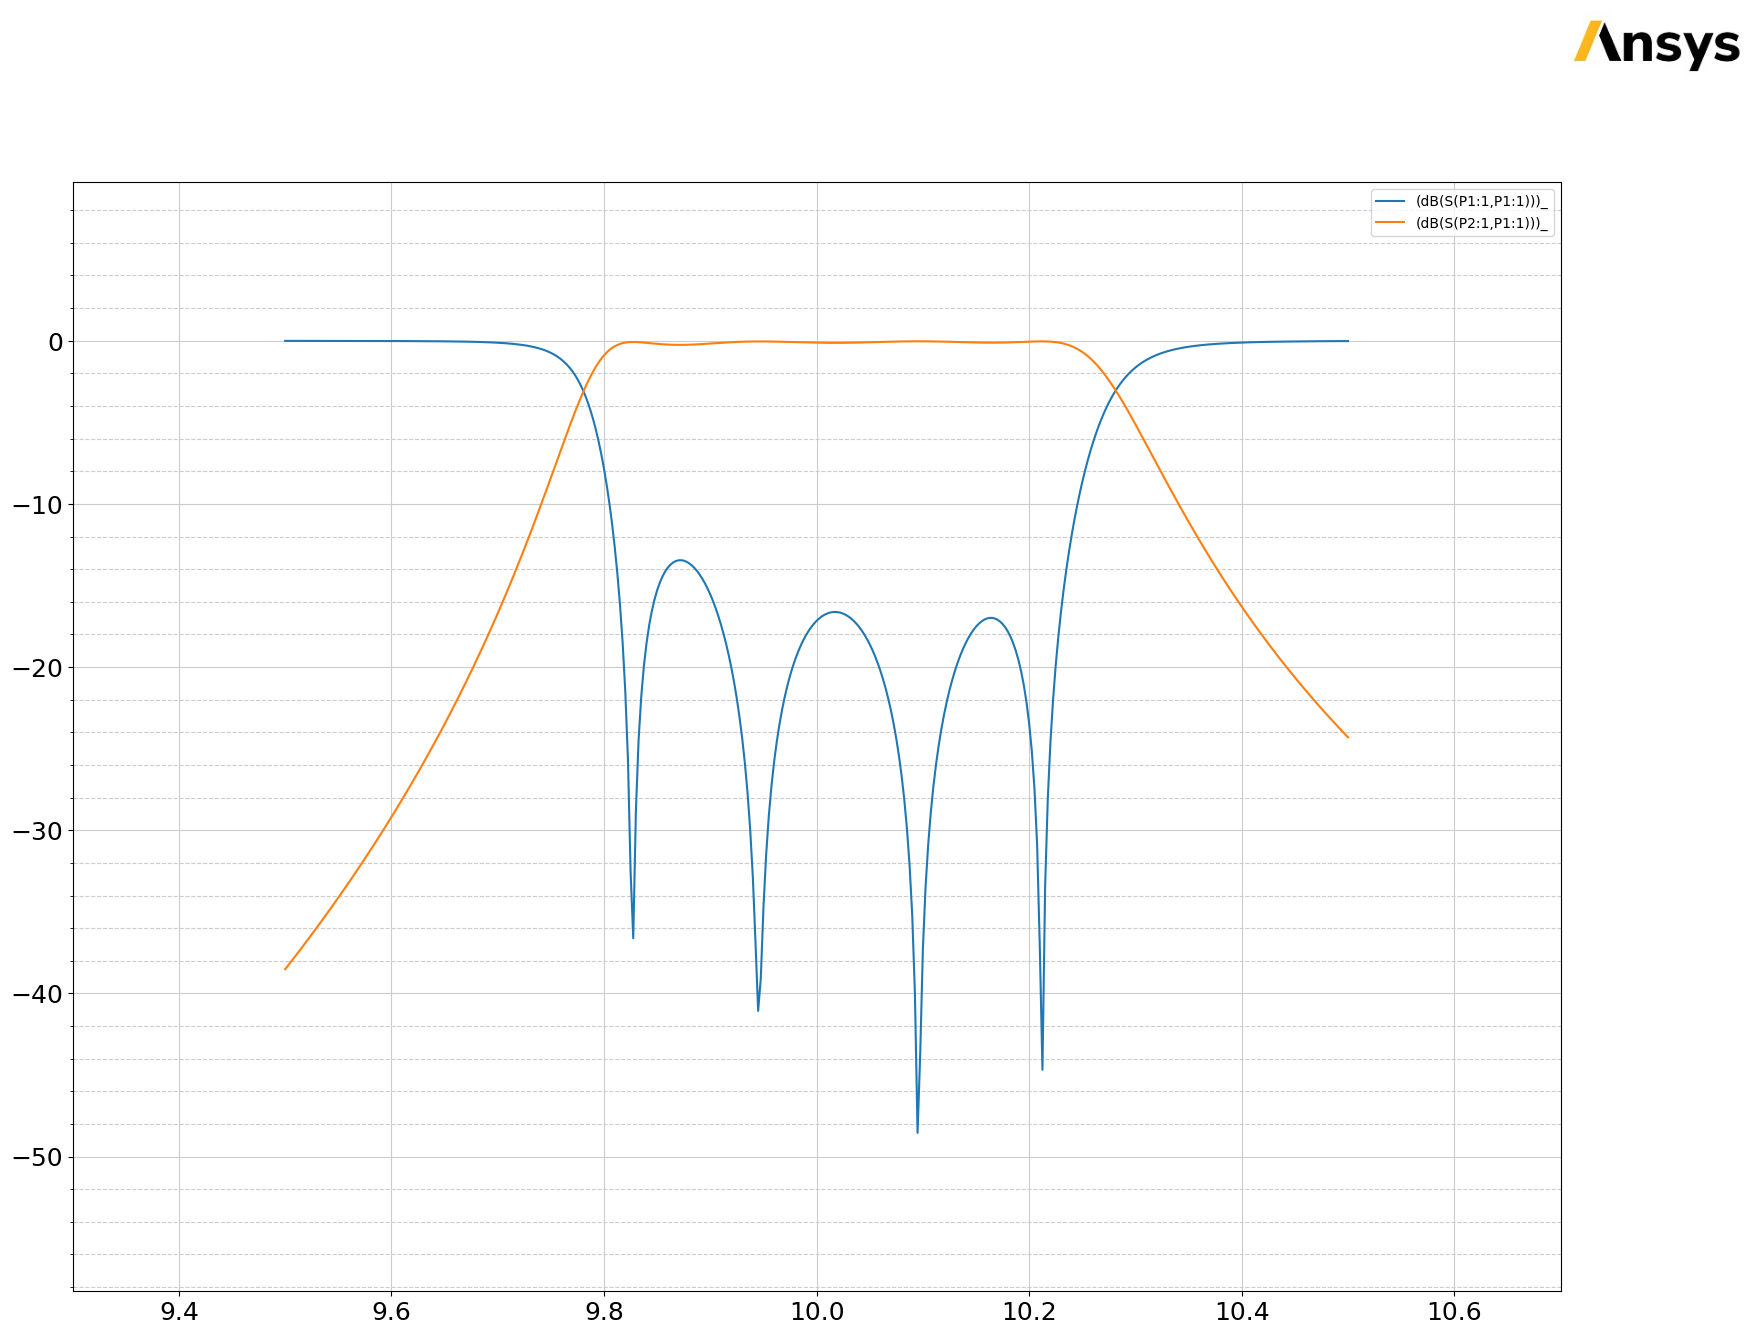

In [14]:
traces_to_plot = hfss.get_traces_for_plot(second_element_filter="P1*")
report = hfss.post.create_report(traces_to_plot)  # Creates a report in HFSS
solution = report.get_solution_data()

plt = solution.plot(solution.expressions)  # Matplotlib axes object.

 The following command generates a field plot in HFSS and uses PyVista
 to plot the field in Jupyter.

In [15]:
plot = hfss.post.plot_field(
    quantity="Mag_E",
    assignment=["Global:XZ"],
    plot_type="CutPlane",
    setup=hfss.nominal_adaptive,
    intrinsics={"Freq": "9.8GHz", "Phase": "0deg"},
    export_path=hfss.working_directory,
    show=False,
)

PyAEDT INFO: Active Design set to filter


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Release AEDT

 The following command saves the project to a file and closes AEDT.

In [16]:
hfss.save_project()
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project waveguide Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes
all temporary files, including the project folder.

In [17]:
temp_folder.cleanup()